# Politics and the stock market

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from IPython.display import Image, display

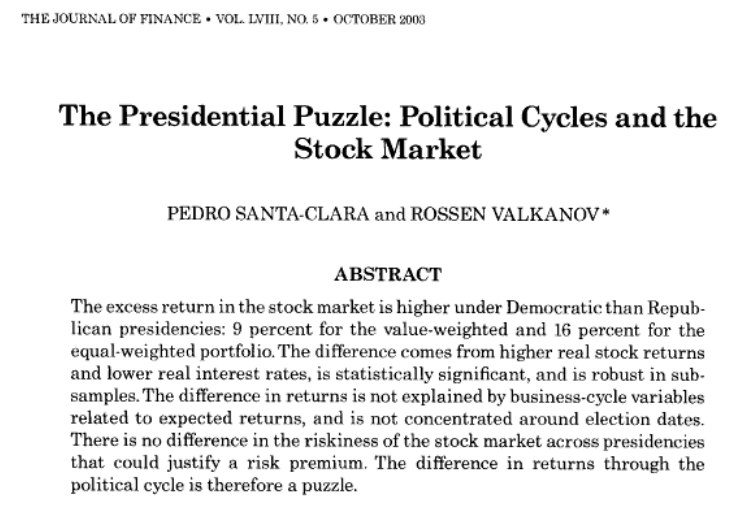

In [2]:
# hide
display(Image("images/santa_clara_valkanov.png", width=600))

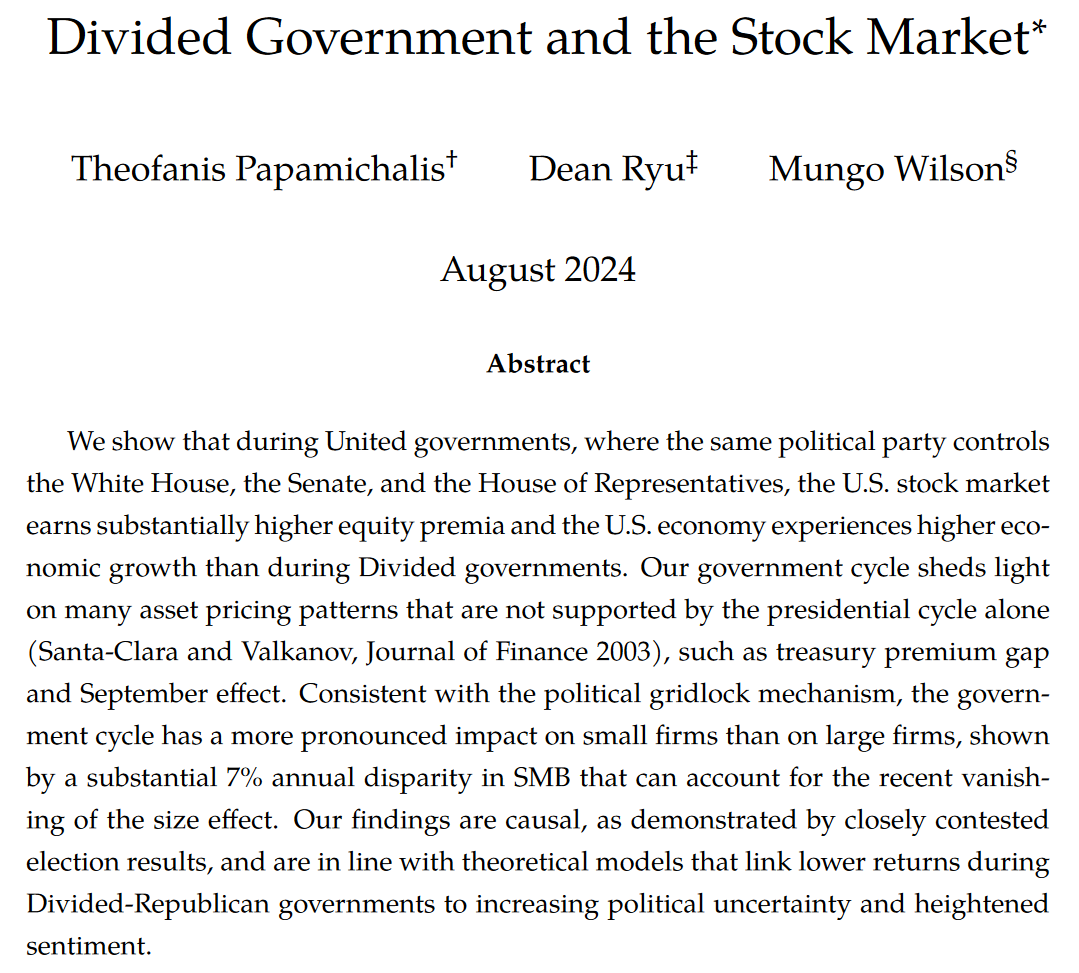

In [3]:
# hide
display(Image("images/papamichalis_ryu_wilson.png", width=600))

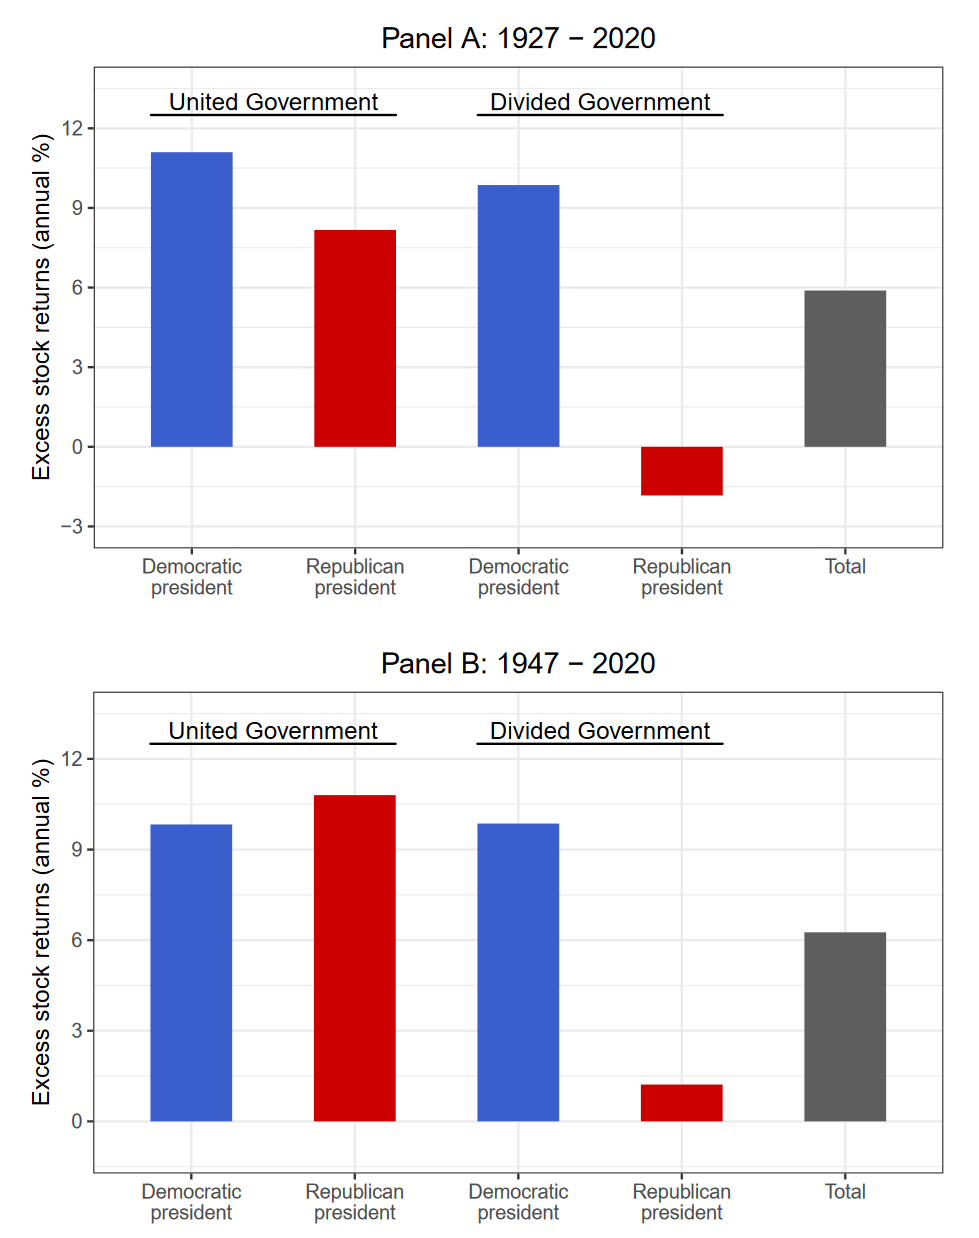

In [4]:
# hide
display(Image("images/papamichalis_ryu_wilson_table.png", width=600))

In [5]:
import pandas as pd
from skfin.metrics import sharpe_ratio
from skfin.plot import *

from skfin.datasets_ import load_kf_returns

ret = load_kf_returns(filename="F-F_Research_Data_Factors")["Monthly"]

INFO:skfin.dataloaders.cache:Loading from cache : data/F-F_Research_Data_Factors


In [6]:
end_date = "2022-10-01"  # Midterm election during Biden's term

In [7]:
from skfin.dataloaders.constants.dates import load_us_politics_dates

In [8]:
cols = ["Presidency", "House", "Senate"]
cols_ = ret.columns
government_ffill_shift = (
    lambda x, cols: x[cols]
    .shift(1)
    .ffill()
    .join(x.drop(cols, axis=1).dropna(), how="right")
)
df = (
    load_us_politics_dates()
    .resample("MS")
    .last()
    .join(ret, how="outer")
    .pipe(government_ffill_shift, cols)
    .assign(
        united_government=lambda x: x[cols].apply(
            lambda row: row.nunique() == 1, axis=1
        ),
        democratic_president=lambda x: x["Presidency"] == "Democratic",
    )
    .loc[:end_date]
)

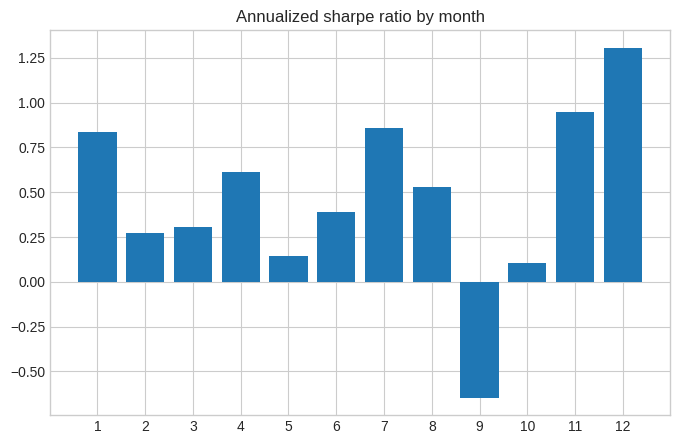

In [9]:
bar(
    df.groupby(lambda x: x.month)["Mkt-RF"].apply(sharpe_ratio, num_period_per_year=12),
    sort=False,
    title="Annualized sharpe ratio by month",
)

In [10]:
vars = ["democratic_president", "united_government"]

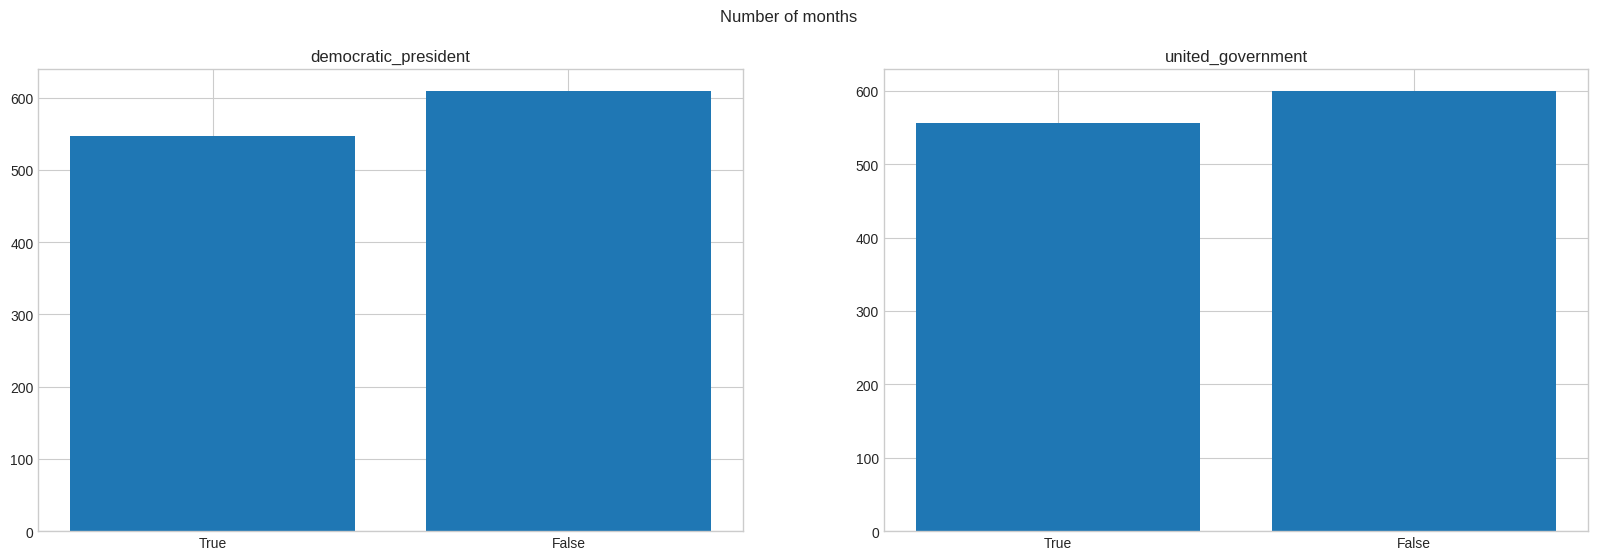

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle("Number of months")
for i, c in enumerate(vars):
    bar(df.groupby(c)["RF"].count(), ax=ax[i], title=c)

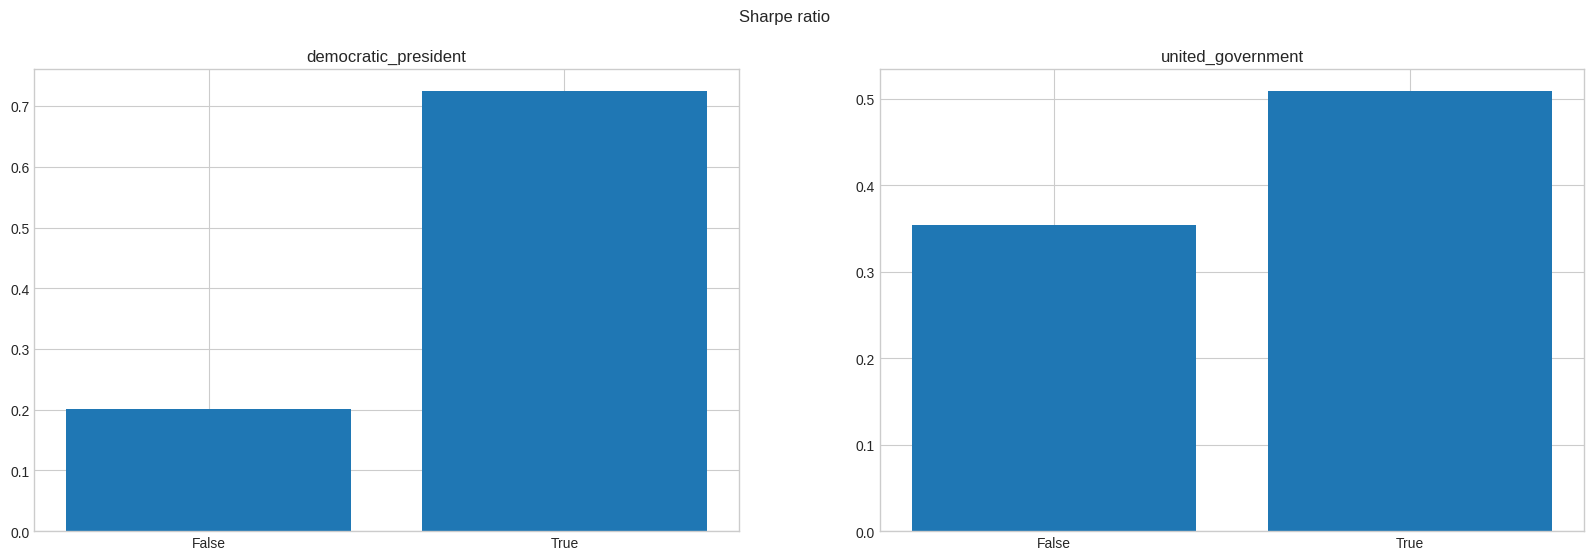

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle("Sharpe ratio")
for i, c in enumerate(vars):
    bar(
        df.groupby(c)["Mkt-RF"].apply(sharpe_ratio, num_period_per_year=12),
        ax=ax[i],
        title=c,
    )

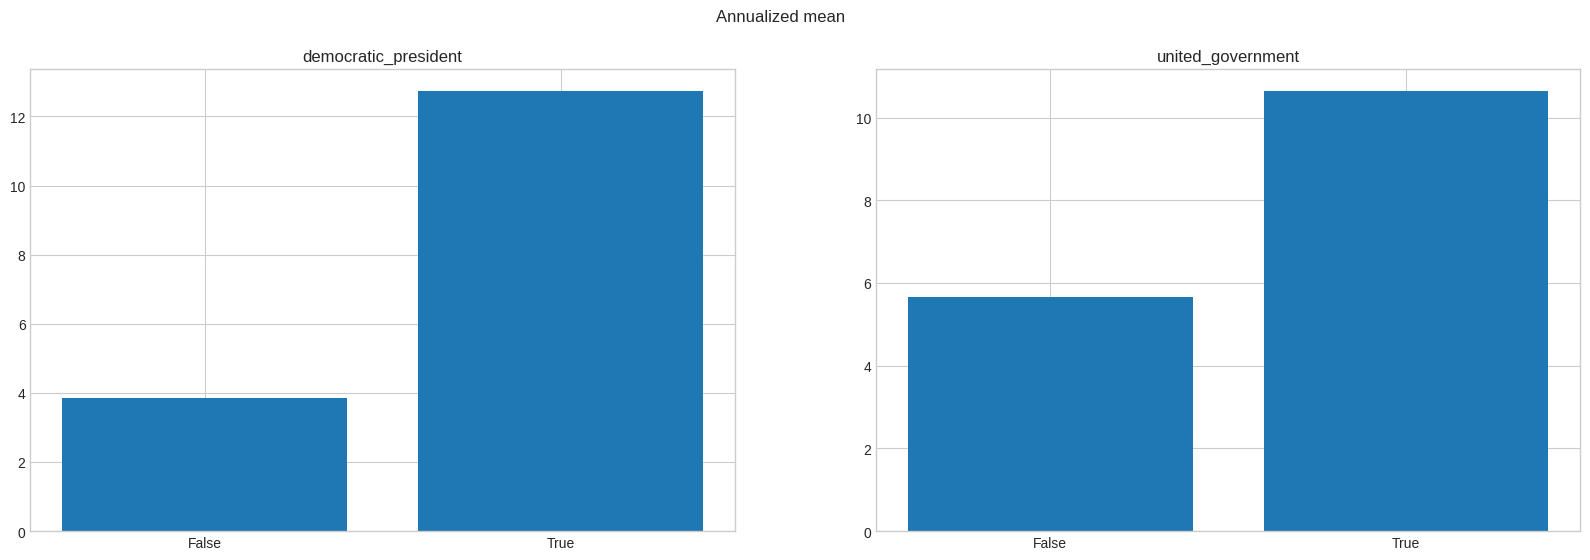

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle("Annualized mean")
for i, c in enumerate(vars):
    bar(df.groupby(c)["Mkt-RF"].mean().mul(12), ax=ax[i], title=c)

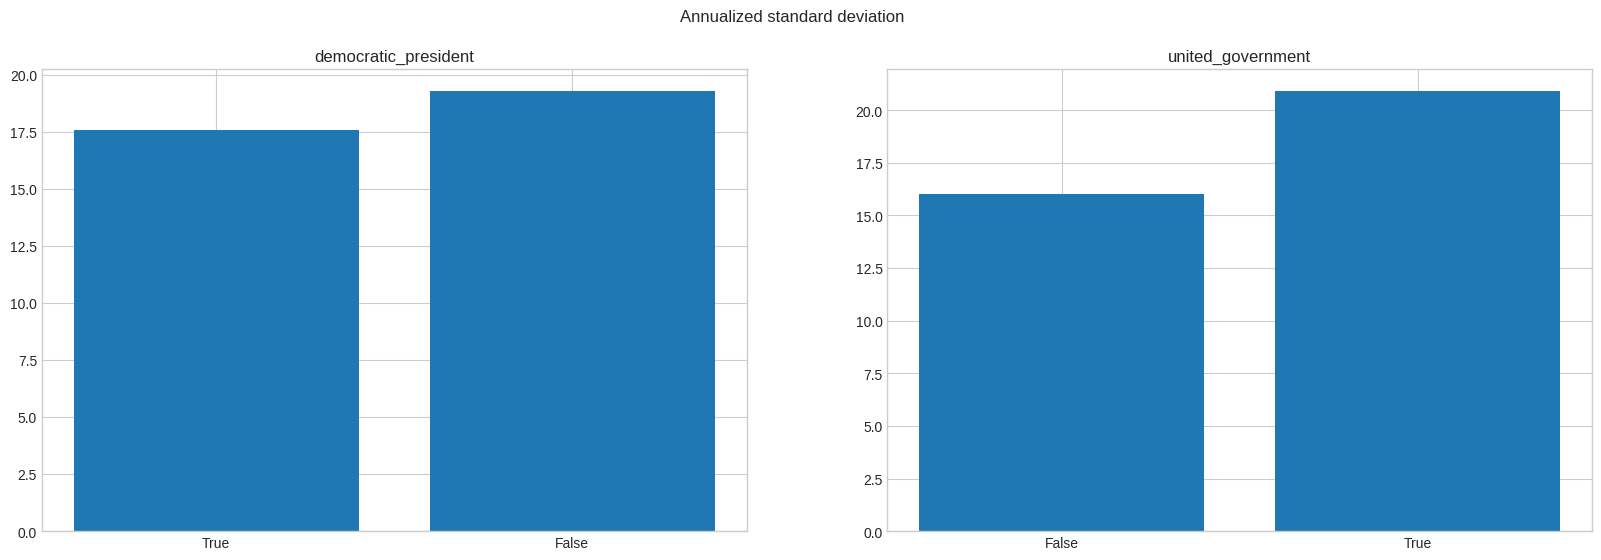

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle("Annualized standard deviation")
for i, c in enumerate(vars):
    bar(df.groupby(c)["Mkt-RF"].std().mul(np.sqrt(12)), ax=ax[i], title=c)

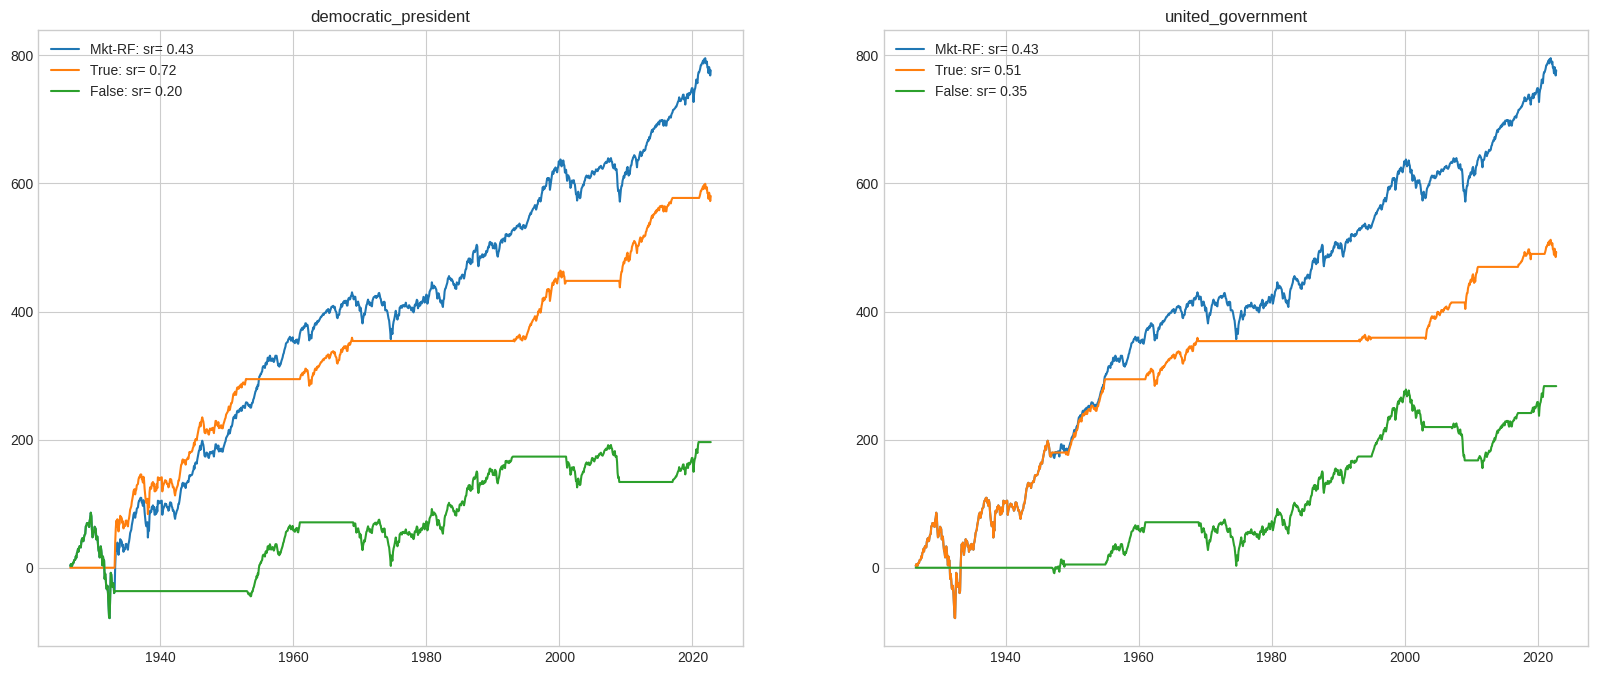

In [15]:
q = "Mkt-RF"
c = "united_government"

dfs = {
    c: df.assign(**{c: lambda x: x[c].apply(str)})
    .set_index(c, append=True)[q]
    .unstack()
    .fillna(0)
    .join(ret[q])
    for c in vars
}

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i, (k, v) in enumerate(dfs.items()):
    line(v, cumsum=True, title=k, ax=ax[i], loc="best")